# Introduction

The purpose of this analysis is to explore a variety of health-related factors and their relationships to accurately classify diabetes. Factors such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level will be investigated.

To achieve this, several techniques will be employed:

1. Exploratory Data Analysis (EDA): To gain initial insights into the dataset's structure and highlight key trends.
2. Univariate, Bivariate, and Multivariate Analyses: These approaches will explore individual variables, relationships between pairs of variables, and interactions among multiple variables, respectively, to better understand their impact on diabetes risk.
3. Data Processing and Cleaning: Ensuring the data is appropriately handled, with any missing or inconsistent entries addressed, and suitable transformations or encodings applied as necessary.
4. Model Comparison: A comparison between two machine learning models—a Logistic Regression and a Random Forest Classifier—will be conducted. Each model's performance will be evaluated and contrasted to determine which better predicts diabetes based on key metrics like accuracy, precision, recall, and AUC.

By combining these techniques, the analysis aims to uncover significant patterns and interactions among health factors that influence diabetes risk

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('diabetes_prediction_dataset.csv')

# 1) EDA and data cleaning

## 1.1) Understanding the dataset

### 1.1.1) Info: nulls, shape, dtypes

In [8]:
print('###################### Info ######################')
print(df.info())

###################### Info ######################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


### 1.1.2) Description of the dataframe

In [9]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,41.89,0.07,0.04,27.32,5.53,138.06,0.09
std,22.52,0.26,0.19,6.64,1.07,40.71,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.63,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,60.00,0.00,0.00,29.58,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


### 1.1.3) Contents of the dataframe

In [10]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
# Let's understand what values we have in each column
for col in df.columns:
    values = [str(v) for v in df[col].sort_values().unique()] 
    if len(values) <= 10:
        print(f'{col}: {", ".join(values)}')
    else:
        print(f'{col} has continuous values.')

gender: Female, Male, Other
age has continuous values.
hypertension: 0, 1
heart_disease: 0, 1
smoking_history: No Info, current, ever, former, never, not current
bmi has continuous values.
HbA1c_level has continuous values.
blood_glucose_level has continuous values.
diabetes: 0, 1


### Summary of dataset exploration:
- The dataset is 100k rows, 9 features
- We don't have nulls.
- Only 8.5% of total samples have diabetes. This class is therefore underrepresented and we should probably do some kind of synthetic resampling.
- We have a mix of data types: 
    - Continuous variables: age, bmi, HbA1c level and blood glucose
    - Binary variables: hypertension and heart disease, and of course diabetes which is our y
    - Categorical variables: smoking history
- Smoking history has a No Info value which is maybe a string for null values. We'll have to do some sort of handling.     

### 1.2) Data quality

### 1.2.1) Null values

In [12]:
# Look for null values in the dataset
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

### 1.2.2) Duplicates

In [13]:
# Look for & drop duplicated values
duplicates = len(df[df.duplicated()]) / len(df)
print(f'There are {duplicates*100:.2f}% duplicates. Lets drop them.')
df_clean = df.drop_duplicates().copy()

There are 3.85% duplicates. Lets drop them.


## 1.2) Let's explore the data! 

We'll do some univariate analysis to understand the distribution of the different features. Then we'll run some bivariate analyses. We'll end up running a correlation analysis. 

### 1.2.1) Univariate analysis

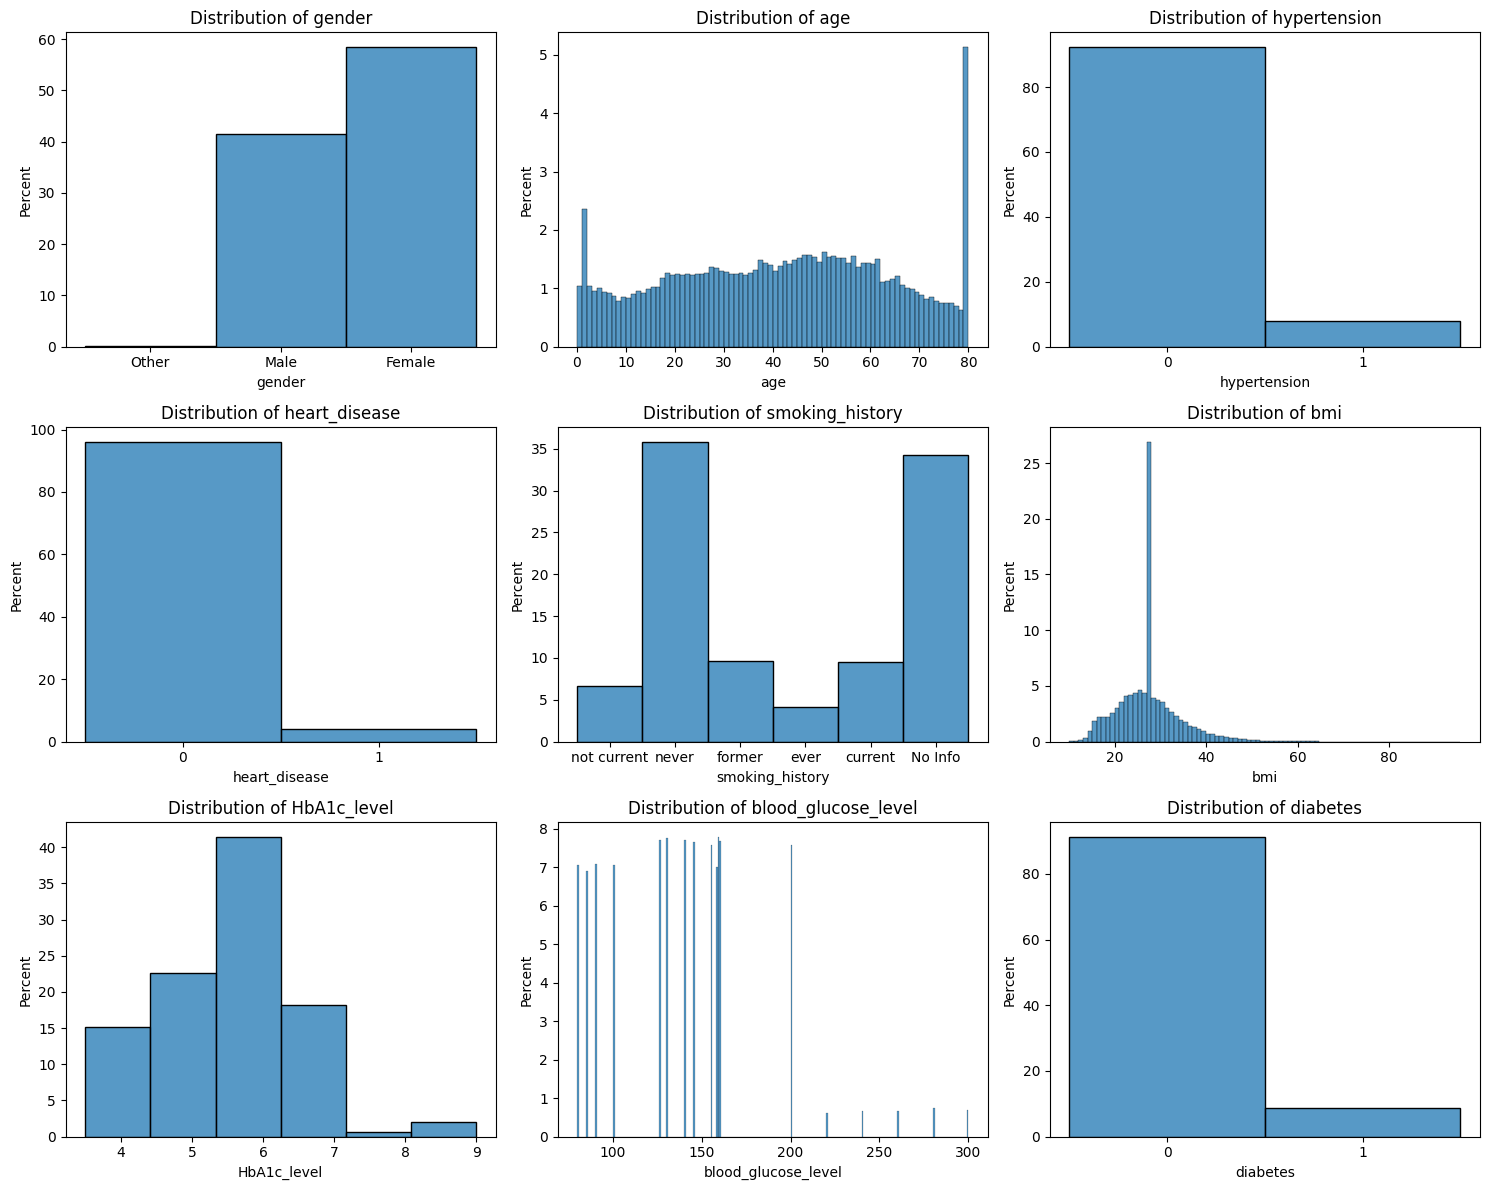

In [14]:
# We'll plot the distribution of all features
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten the axes for easier iteration

for i, col in enumerate(df_clean.columns):
    df_temp = df_clean.sort_values(col, ascending=False)
    
    unique_vals = df_temp[col].dropna().unique()
    is_binary = np.array_equal(unique_vals, [0, 1]) or np.array_equal(unique_vals, [1, 0])
    
    if is_binary:
        sns.histplot(df_temp, x=col, ax=axes[i], stat='percent', discrete=True)
        axes[i].set_xticks([0, 1]) 
    else:
        sns.histplot(df_temp, x=col, ax=axes[i], stat='percent', binwidth=1)
    
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()    

In [15]:
# Let's have a closer look at the weird peak of age at 80
df_clean.groupby('age').count().sort_values('diabetes', ascending=False).reset_index().head()

,age,gender,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80.0,4932,4932,4932,4932,4932,4932,4932,4932
1,51.0,1566,1566,1566,1566,1566,1566,1566,1566
2,47.0,1511,1511,1511,1511,1511,1511,1511,1511
3,48.0,1508,1508,1508,1508,1508,1508,1508,1508
4,53.0,1498,1498,1498,1498,1498,1498,1498,1498


In [16]:
# bmi shows a weird peak around the mean. Possibly due to the synthetic creation of this dataset
df_clean.groupby('bmi').count().sort_values('diabetes', ascending=False).reset_index().head()

,bmi,gender,age,hypertension,heart_disease,smoking_history,HbA1c_level,blood_glucose_level,diabetes
0,27.32,21666,21666,21666,21666,21666,21666,21666,21666
1,23.00,103,103,103,103,103,103,103,103
2,27.12,101,101,101,101,101,101,101,101
3,27.80,100,100,100,100,100,100,100,100
4,24.96,100,100,100,100,100,100,100,100


In [17]:
print(f'There are {(len(df[df.gender == "Other"]) / len(df) * 100):.3f}% Other')
df_clean = df_clean[df_clean.gender!='Other']

There are 0.018% Other


### ℹ️ Summary of initial findings
- We have an Other gender which accounts for only 0.018% of samples. We can probably drop them safely. 
- The No Info smoking status accounts for almost 35% of samples. We can't drop them, so we'll need to consider other options.
- There are weird peaks in age and bmi, most likely due to the preprocessing of the data
    - Looking at the dataset definition, we see that data from different sources was aggregated, cleaned and preprocessed. bmi nulls were probably filled with the mean, and the age was probably truncated at 80 so outliers wouldn't show. 

### 1.2.2) Bivariate analysis

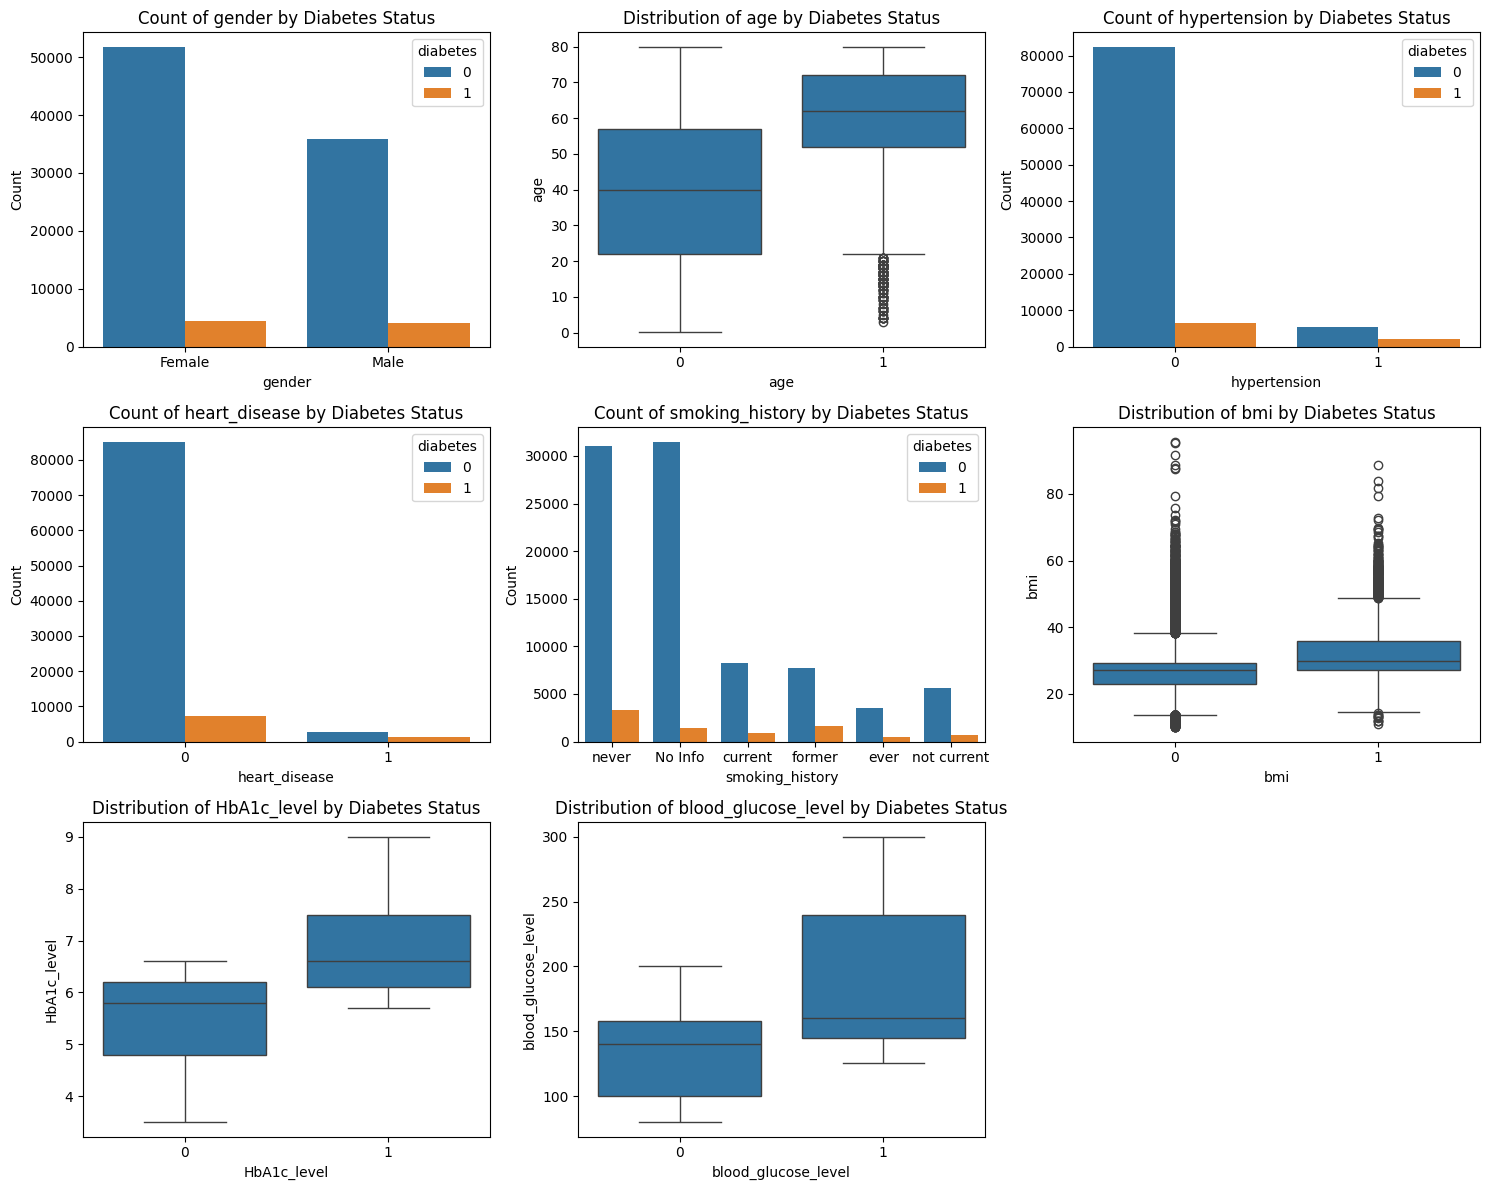

In [18]:
# We'll plot each feature compared to our variable of interest (diabtes) to have a quick idea of which are more related with diabetes
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten the axes for easier iteration

feature_cols = [col for col in df_clean.columns if col != 'diabetes']

for i, col in enumerate(feature_cols):
    ax = axes[i]
    unique_vals = df_clean[col].dropna().unique()
    is_binary = np.array_equal(np.sort(unique_vals), [0, 1]) or np.array_equal(np.sort(unique_vals), [1, 0])

    if df_clean[col].dtype == 'object' or df_clean[col].nunique() < 10: 
        sns.countplot(data=df_clean, x=col, hue='diabetes', ax=ax)
        ax.set_title(f'Count of {col} by Diabetes Status')
        ax.set_xticklabels(ax.get_xticklabels())
    elif is_binary:
        sns.countplot(data=df_clean, x=col, hue='diabetes', ax=ax)
        ax.set_title(f'Count of {col} (Binary) by Diabetes Status')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0', '1'])
    else:
        sns.boxplot(data=df_clean, x='diabetes', y=col, ax=ax)
        ax.set_title(f'Distribution of {col} by Diabetes Status')
    
    ax.set_xlabel(col)
    ax.set_ylabel('Count' if df_clean[col].dtype == 'object' or is_binary else col)

if len(feature_cols) < len(axes):
    for j in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[j])    
    
plt.tight_layout()
plt.show()

#### Double click on categorical features: What's the % of people with diabetes in each feature's categories? 

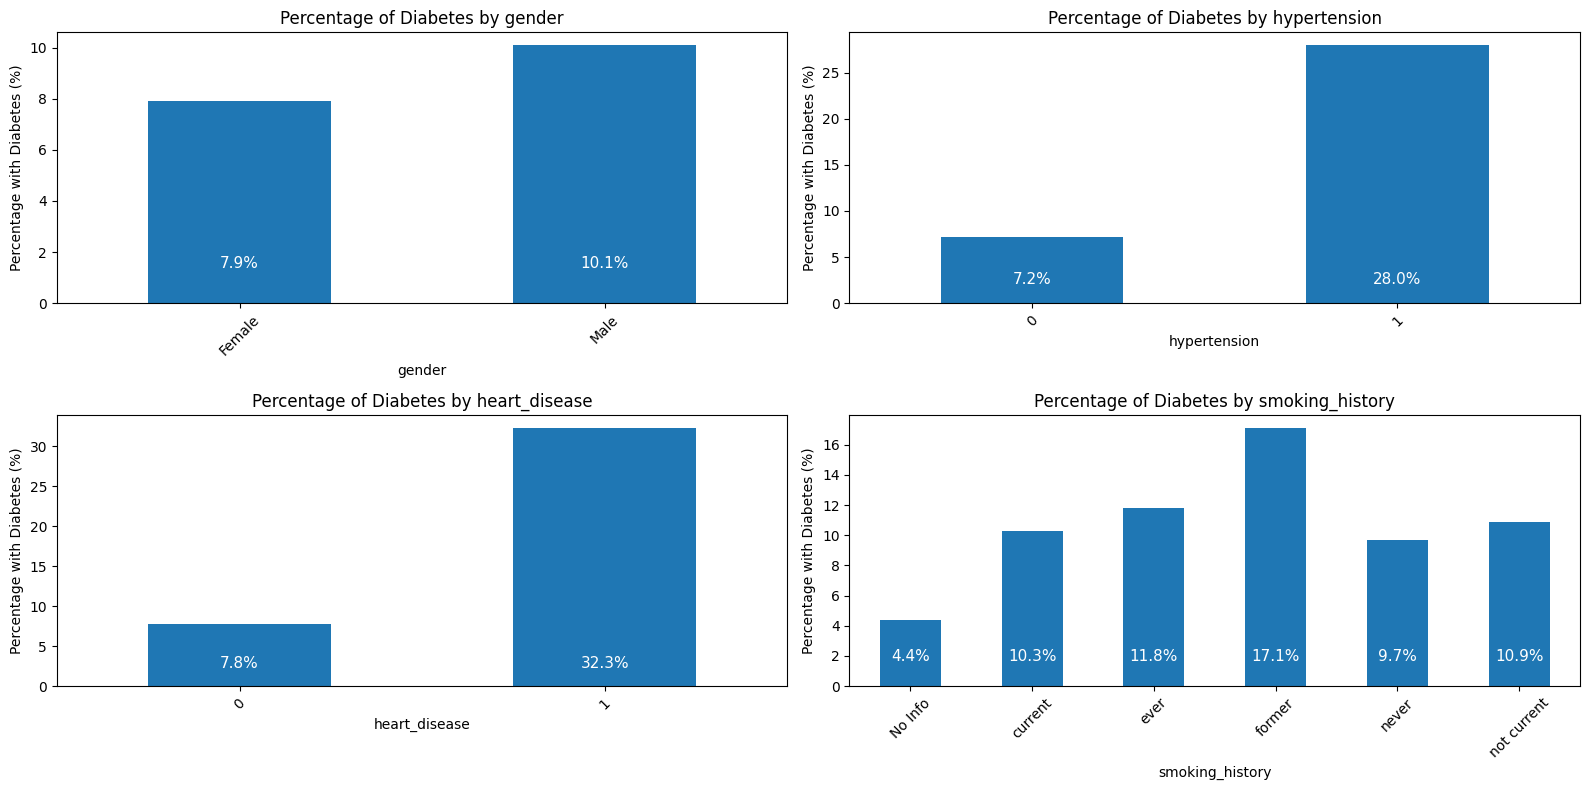

In [19]:
categorical_features = [col for col in feature_cols if df_clean[col].dtype == 'object' or df_clean[col].nunique() < 10]

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    percentages = df_clean.groupby(col)['diabetes'].mean() * 100
    percentages.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Percentage of Diabetes by {col}')
    axes[i].set_ylabel('Percentage with Diabetes (%)')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)
    
    for p in axes[i].patches:
        axes[i].annotate(f"{p.get_height():.1f}%", 
                         (p.get_x() + p.get_width() / 2., 1), 
                         ha='center', va='bottom', 
                         fontsize=11, color='white', xytext=(0, 5),
                         textcoords='offset points')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

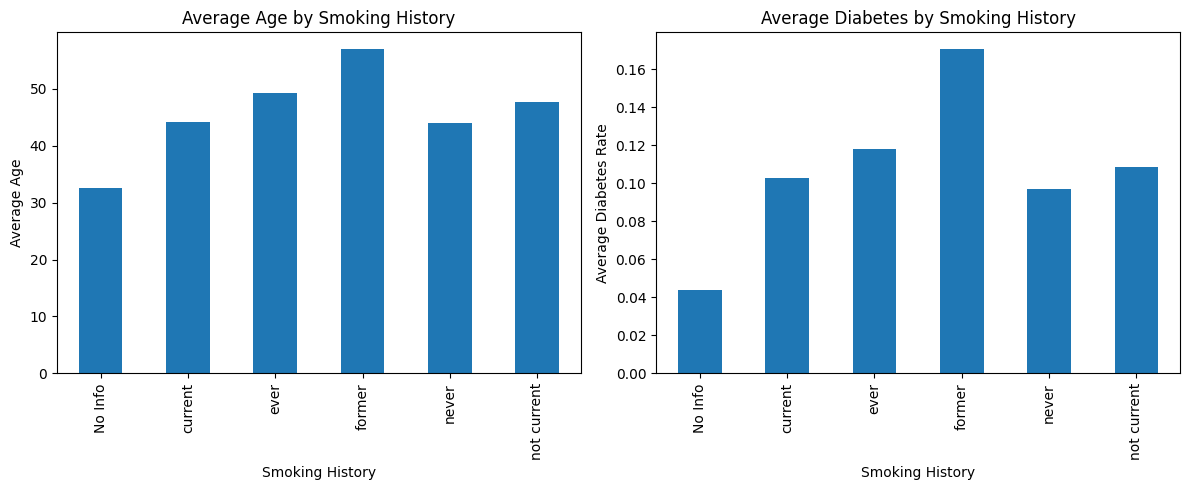

In [20]:
# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot average age by smoking history
df_clean.groupby('smoking_history').mean(numeric_only=True)['age'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Average Age by Smoking History')
axes[0].set_xlabel('Smoking History')
axes[0].set_ylabel('Average Age')

# Plot average diabetes rate by smoking history
df_clean.groupby('smoking_history')['diabetes'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Diabetes by Smoking History')
axes[1].set_xlabel('Smoking History')
axes[1].set_ylabel('Average Diabetes Rate')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### ℹ️ Summary of insights
- Diabetes affects more:
    - males
    - older people
    - people with hyper-tension-
    - heart diseases
    - high bmi
    - high hbA1c levels
    - high glucose levels
- Smoking status could also be a factor, but it seems that the 'former' status is related to age (as one needs time to become a 'former' smoker), and therefore, it could be a confounding variable.
- If this is true, seems like No Info means non-smokers (never) as it has a low diabetes rate and low age.

### 1.2.3) Let's see how Body Mass Index and High Glucose relates with other features

- 

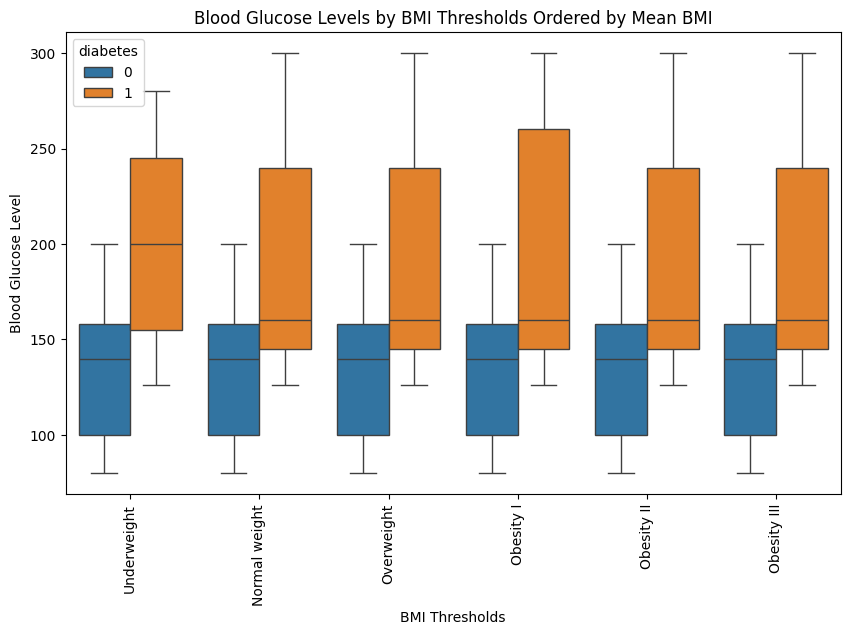

In [21]:
# Define function to categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    elif 30 <= bmi < 35:
        return "Obesity I"
    elif 35 <= bmi < 40:
        return "Obesity II"
    else:
        return "Obesity III"

# Apply the function to create a new column for BMI thresholds
df_clean['bmi_thresholds'] = df_clean['bmi'].apply(categorize_bmi)

# Calculate mean BMI for each category to order the boxplots
mean_bmi_order = df_clean.groupby('bmi_thresholds')['bmi'].mean().sort_values().index.tolist()

# Create boxplot ordered by mean BMI
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='bmi_thresholds', y='blood_glucose_level', order=mean_bmi_order, hue='diabetes')
plt.xticks(rotation=90)
plt.title('Blood Glucose Levels by BMI Thresholds Ordered by Mean BMI')
plt.xlabel('BMI Thresholds')
plt.ylabel('Blood Glucose Level')
plt.show()

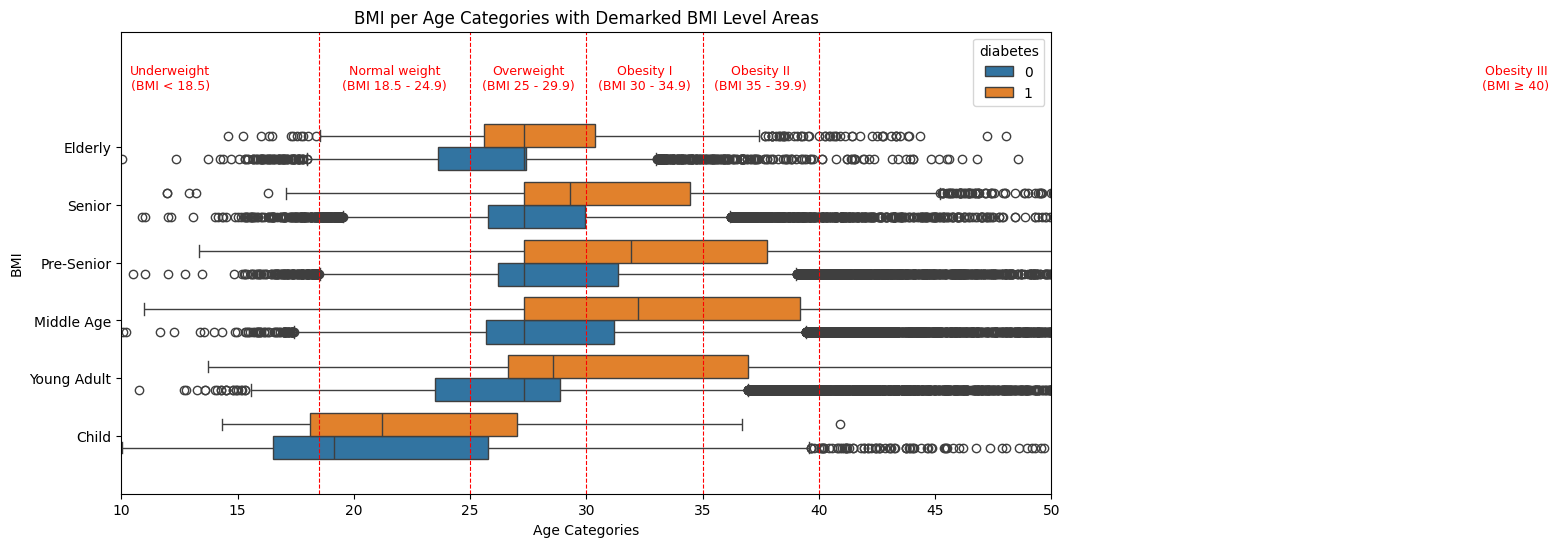

In [22]:
def categorize_age(age):
    if age < 18:
        return "Child"
    elif 18 <= age < 35:
        return "Young Adult"
    elif 35 <= age < 50:
        return "Middle Age"
    elif 50 <= age < 65:
        return "Pre-Senior"
    elif 65 <= age < 80:
        return "Senior"
    else:
        return "Elderly"

df_clean['age_categories'] = df_clean['age'].apply(categorize_age)

mean_age_order = df_clean.groupby('age_categories')['age'].mean().sort_values().index.tolist()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='bmi', y='age_categories', order=mean_age_order, hue='diabetes')

# Define BMI thresholds and labels
bmi_thresholds = {
    'Underweight\n(BMI < 18.5)': 18.5,
    'Normal weight\n(BMI 18.5 - 24.9)': 25.0,
    'Overweight\n(BMI 25 - 29.9)': 30.0,
    'Obesity I\n(BMI 30 - 34.9)': 35.0,
    'Obesity II\n(BMI 35 - 39.9)': 40.0,
    'Obesity III\n(BMI ≥ 40)': plt.gca().get_xlim()[1]  # Use the current x-axis limit
}

# Add vertical lines and labels
previous_threshold = plt.gca().get_xlim()[0]  # Start from the current x-axis minimum
for label, bmi_value in bmi_thresholds.items():
    # Add vertical line
    if bmi_value != plt.gca().get_xlim()[1]:
        plt.axvline(x=bmi_value, color='red', linestyle='--', linewidth=0.8)
    # Add text label in the middle of the interval
    mid_point = (previous_threshold + bmi_value) / 2
    plt.text(
        mid_point,
        6,
        label,
        horizontalalignment='center',
        color='red',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    previous_threshold = bmi_value

# Adjust plot limits for space
plt.ylim(-1, 7)
plt.xlim(10,50)
plt.title('BMI per Age Categories with Demarked BMI Level Areas')
plt.xlabel('Age Categories')
plt.ylabel('BMI')
plt.show()

### 1.2.4 Correlation analysis

In [23]:
def simplify_smoking(status):
    if status in ['never', 'No Info']:
        return 'no_smoker'
    elif status == 'current':
        return 'current_smoker'
    elif status in ['ever', 'former', 'not current']:
        return 'past_smoker'
    
df_clean['smoking_history'] = df_clean['smoking_history'].apply(simplify_smoking)

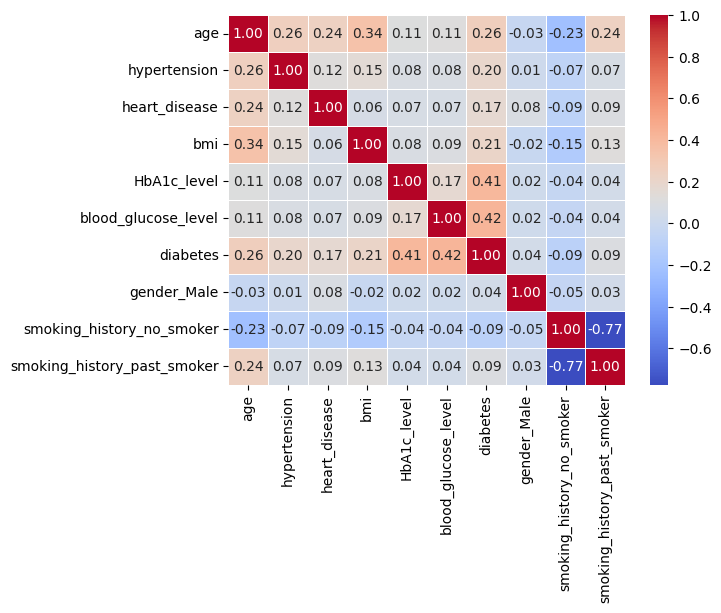

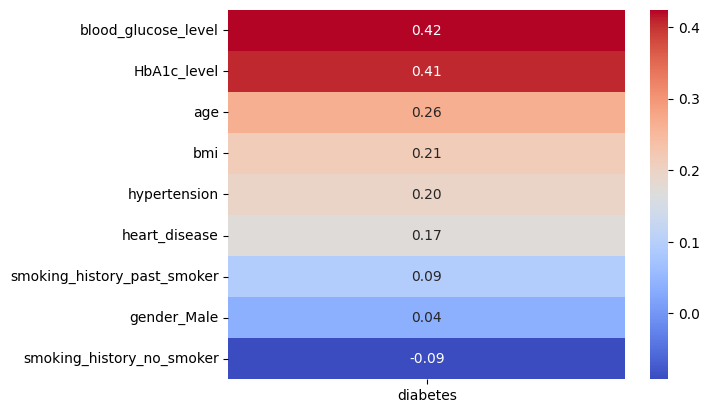

In [24]:
df_corr = df_clean[df_clean.columns[:-2]]
categorical_columns = df_corr.select_dtypes(include=['object', 'category']).columns.tolist()

# For the regression model, we'll need to drop first to avoid multicolinearity
df_regression = pd.get_dummies(df_corr, columns=categorical_columns, drop_first=True)

# For the random forest model, we should keep all categories
df_forest = pd.get_dummies(df_corr, columns=categorical_columns, drop_first=False)

corr = df_regression.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.show()

diabetes_corr = corr['diabetes'].drop('diabetes').sort_values(ascending=False)
sns.heatmap(diabetes_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.show()

# 2) Model selection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

if len(df_clean.columns) > 9:
    df_clean = df_clean[df_clean.columns[:-2]]

df_encoded = pd.get_dummies(df_clean, columns=['gender', 'smoking_history'], drop_first=True)

X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

# Feature Scaling to improve regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Hyperparameter tuning for Logistic Regression - just over thinking this part but looking to see if a logistic would be enough.
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 500, 1000]
    },
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'sag', 'saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 500, 1000]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.5, 0.7, 0.9],
        'solver': ['saga'],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 500, 1000]
    },
    {
        'penalty': [None],
        'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 500, 1000]
    }
]
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train_resampled, y_train_resampled)

# Best estimator
model = grid.best_estimator_

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Diabetes', 'Diabetes'],
    yticklabels=['No Diabetes', 'Diabetes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


NameError: name 'df_clean' is not defined

**1. Classification Report:**
The table shows performance metrics for a binary classification model predicting two classes: "0" (No Diabetes) and "1" (Diabetes).

- Class "0" (No Diabetes):

    - Precision: 0.99 – This means that when the model predicts "No Diabetes," it is correct 99% of the time.
    - Recall: 0.86 – Out of all actual "No Diabetes" cases, the model correctly identifies 86%.
    - F1-Score: 0.92 – The harmonic mean of precision and recall, indicating a strong balance between them.
    - Support: 17,530 instances of "No Diabetes."

- Class "1" (Diabetes):

    - Precision: 0.38 – When the model predicts "Diabetes," it's correct only 38% of the time.
    - Recall: 0.91 – Out of all actual "Diabetes" cases, the model correctly identifies 91%.
    - F1-Score: 0.54 – Lower than class "0" due to the imbalance between precision and recall.
    - Support: 1,696 instances of "Diabetes."
    
- Overall Metrics:

    - Accuracy: 0.86 – The model correctly classifies 86% of all cases.
    - Macro avg: The average of precision, recall, and F1-score across both classes, providing a more balanced overview.
    - Weighted avg: Takes into account the support (number of instances) for each class, which is useful when classes are imbalanced.

The report indicates that while the model performs well for predicting "No Diabetes" (high precision and recall), it struggles with correctly predicting "Diabetes," as seen in the low precision for class "1."

**2. Receiver Operating Characteristic (ROC) Curve:**

The ROC curve plots the True Positive Rate (Recall) against the False Positive Rate at different classification thresholds. The closer the curve follows the top-left corner, the better the model is at distinguishing between the two classes.

- AUC (Area Under Curve): 0.96 – This is a high AUC, indicating that the model has a strong overall ability to discriminate between the positive and negative classes (here, "Diabetes" and "No Diabetes").

**3. In summary:**

The model has a strong ability to correctly identify "No Diabetes" but struggles with precision in predicting "Diabetes."
The ROC curve and AUC suggest good overall performance, but the imbalance in class prediction should be addressed, particularly improving precision for the "Diabetes" class. Balancing the classes or adjusting the classification threshold might improve this.

Fitting 3 folds for each of 20 candidates, totalling 60 fits


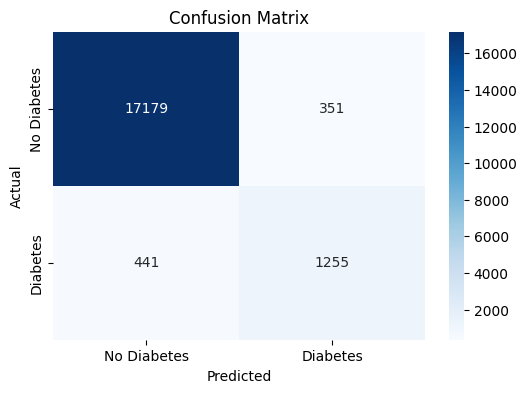

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17530
           1       0.78      0.74      0.76      1696

    accuracy                           0.96     19226
   macro avg       0.88      0.86      0.87     19226
weighted avg       0.96      0.96      0.96     19226



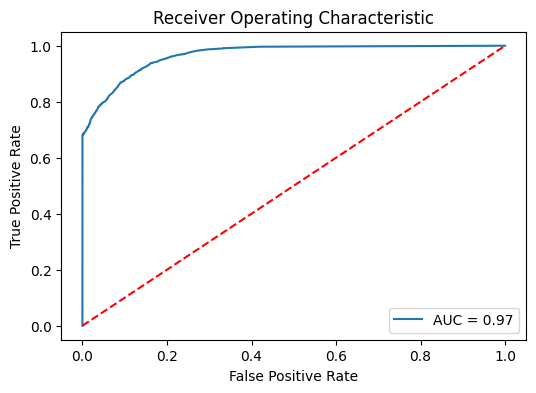

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_clean, columns=['gender', 'smoking_history'], drop_first=True)

# Separate features and target
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

# Split into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance with SMOTE (Over Sampling only)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reduced parameter grid for faster RandomForestClassifier tuning
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    cv=3,  # Reduce the number of folds to speed up
    scoring='f1',
    n_jobs=-1,
    n_iter=20,  # Limit the number of parameter combinations
    verbose=1,
    random_state=42
)

random_search.fit(X_train_resampled, y_train_resampled)

model = random_search.best_estimator_

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Diabetes', 'Diabetes'],
    yticklabels=['No Diabetes', 'Diabetes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### 1. Classification Report
The table below summarizes the performance metrics for a binary classification model predicting "No Diabetes" (class 0) and "Diabetes" (class 1).

- **Class "0" (No Diabetes)**
  - **Precision**: **0.97** – When the model predicts "No Diabetes," it is correct 97% of the time.
  - **Recall**: **0.98** – Out of all actual "No Diabetes" cases, the model correctly identifies 98%.
  - **F1-Score**: **0.98** – The harmonic mean of precision and recall, indicating strong predictive performance.
  - **Support**: **17,530** instances of "No Diabetes."
  

- **Class "1" (Diabetes)**
  - **Precision**: **0.78** – When the model predicts "Diabetes," it is correct 78% of the time.
  - **Recall**: **0.74** – Out of all actual "Diabetes" cases, the model correctly identifies 74%.
  - **F1-Score**: **0.76** – Reflects the balance between precision and recall; lower compared to class "0".
  - **Support**: **1,696** instances of "Diabetes."

- **Overall Metrics**
  - **Accuracy**: **0.96** – The model correctly classifies 96% of all cases.
  - **Macro Average**: 
    - **Precision**: 0.88
    - **Recall**: 0.86
    - **F1-Score**: 0.87
  - **Weighted Average**: Takes into account the number of instances for each class.
    - **Precision**: 0.96
    - **Recall**: 0.96
    - **F1-Score**: 0.96

The classification report indicates that the model performs very well in predicting "No Diabetes" but has slightly lower precision and recall in identifying "Diabetes."

### 2. ROC Curve
The Receiver Operating Characteristic (ROC) curve is used to visualize the model's performance:

- **True Positive Rate (Recall)** is plotted against the **False Positive Rate** at various threshold settings.
- The **AUC (Area Under the Curve)** is **0.97**, which indicates a high level of overall performance.
  - An AUC closer to 1 indicates better performance, while an AUC closer to 0.5 would suggest no better than random guessing.
- The diagonal red line represents the performance of a random classifier (AUC = 0.5). The further the blue line is from this diagonal, the better the model's performance.

Overall, the model has a strong ability to discriminate between the "No Diabetes" and "Diabetes" classes, as evidenced by the high AUC and classification metrics.

# 3) Conclusion

Comparing two classification models – **Logistic Regression** and **Random Forest** – we observe key performance differences:

- **Logistic Regression:**
  - **Accuracy**: 86%
  - **Class "0" (No Diabetes) Performance**:
    - **Precision**: 99%
    - **Recall**: 86%
  - **Class "1" (Diabetes) Performance**:
    - **Precision**: 38%
    - **Recall**: 91%
  - **F1-Score (Diabetes)**: 0.54 – indicating difficulties in correctly predicting positive cases.
  - **AUC**: 0.96 – Strong overall discriminatory power.
  
- **Random Forest:**
  - **Accuracy**: 96%
  - **Class "0" (No Diabetes) Performance**:
    - **Precision**: 97%
    - **Recall**: 98%
  - **Class "1" (Diabetes) Performance**:
    - **Precision**: 78%
    - **Recall**: 74%
  - **F1-Score (Diabetes)**: 0.76 – a balanced score for correctly predicting positive cases.
  - **AUC**: 0.97 – Slightly improved discriminatory power over Logistic Regression.
  
### Key Observations
- The **Random Forest** model outperforms **Logistic Regression** in overall accuracy (96% vs. 86%) and provides better balanced precision-recall for predicting "Diabetes."
- Logistic Regression has higher **Recall for Diabetes** but very low **Precision**, leading to a high number of false positives.
- The **AUC** scores are quite high for both models, indicating strong overall model performance in distinguishing between "No Diabetes" and "Diabetes."

## Suggestions for Improvement / Next Steps
1. **Feature Engineering**: Analyze feature importance, especially for the Random Forest model, to identify and engineer new features that may improve model performance on "Diabetes." For example, binning on age and bmi as done in the EDA.
2. **Handle Class Imbalance More Effectively**: While SMOTE was used to address class imbalance, experimenting with different resampling techniques (e.g., **ADASYN**, **Tomek Links**) or adjusting class weights in the models could further improve performance on minority classes.
3. **Ensemble Methods & Model Comparison**: Explore other ensemble methods (e.g., **Gradient Boosting**, **XGBoost**) and compare their performance with Random Forest. Use **cross-validation** to evaluate models under different conditions and prevent overfitting.
